In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
from photutils import RectangularAperture, aperture_photometry
import glob, pdb, mpld3, batman
from mpld3 import plugins
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = (12, 6)
mpld3.enable_notebook()

In [2]:
fnames = ascii.read('filenames.csv')
len(fnames)

396

In [3]:
img_list = []
hdr_list = []
for fn in fnames:
    hdu = fits.open(fn[0])
    header = hdu[0].header
    if header['OBSTYPE'] == 'SPECTROSCOPIC':
        image = hdu[1].data
        img_list.append(image)
        hdr_list.append(header)
    hdu.close()
len(img_list)

392

In [4]:
lc_info = ascii.read('lc_info.csv')

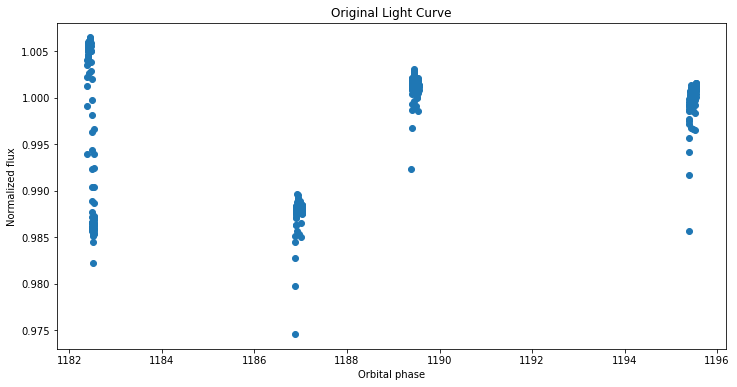

In [5]:
tt        = 2454159.45320
period    = 1.5089557
jd_const  = 2400000.5
norm_flux = lc_info['res_flux']/np.median(lc_info['res_flux'])
op        = np.sort((lc_info['time'] + jd_const - tt)/period)
ind       = np.argsort(lc_info['time'])

fig, ax = plt.subplots()
points = ax.plot(op, norm_flux, 'o')
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('Original Light Curve')

# fig.savefig('Light_Curve.pdf')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
labels = ['{}, {}'.format(i + 1, pa) for i, pa in zip(range(len(op)), lc_info['position angle'][ind])]
tooltip = mpld3.plugins.PointLabelTooltip(points[0], labels=labels)
plugins.connect(fig, tooltip)

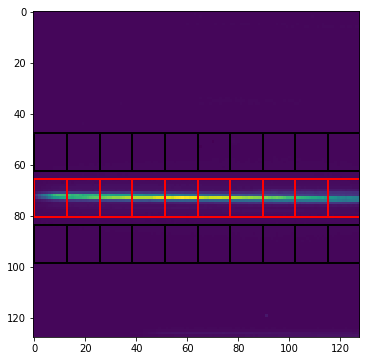

In [6]:
plt.imshow(img_list[10])

y_levels = [73, 91, 55]
width    = 128/10.
start    = 0
while (start < (128-width)):
    for y in y_levels:
        x = start + (width/2.)  
        aper = RectangularAperture((x, y), w = width, h = 15, theta = 0.0)
        if y==73 :
            aper.plot(color = 'r', linewidth = 2)
        else:
            aper.plot(color = 'k', linewidth = 2)
    start += width

In [7]:
centers    = ascii.read('centers.csv')
width      = 128/10.
flux_array = np.zeros([392, 10]) #392 images, 10 boxes each

for i, (image, header) in enumerate(zip(img_list, hdr_list)):
    
    y1 = centers[i][1]             #vertical center of every source box 
    y2 = centers[i][1] + 10     #vertical center of every bkg1 box
    y3 = centers[i][1] - 10     #vertical center of every bkg2 box
#     pdb.set_trace()
    mask    = np.isnan(image) == True
    counter = 0
    start   = 0
    
    while (start < (128-width)):      #iterating over every box
        x      = start + (width/2.)   #horizontal center of every box
        src_ap = RectangularAperture((x, y1), w = width, h = 15, theta = 0.0)
        bk_ap1 = RectangularAperture((x, y2), w = width, h = 15, theta = 0.0)
        bk_ap2 = RectangularAperture((x, y3), w = width, h = 15, theta = 0.0)
    
        raw = aperture_photometry(image, src_ap, mask = mask)['aperture_sum']
        
        bkg1 = aperture_photometry(image, bk_ap1, mask = mask)['aperture_sum']
        bkg_mean1 = bkg1/bk_ap1.area()
        bkg_flux1 = bkg_mean1*src_ap.area()
        
        bkg2 = aperture_photometry(image, bk_ap2, mask = mask)['aperture_sum']
        bkg_mean2 = bkg2/bk_ap2.area()
        bkg_flux2 = bkg_mean2*src_ap.area()
        
        bkg = (bkg_flux1 + bkg_flux2)/2
        res = raw - bkg
        
        flux_array[i][counter] = res
        
        start    += width
        counter  += 1

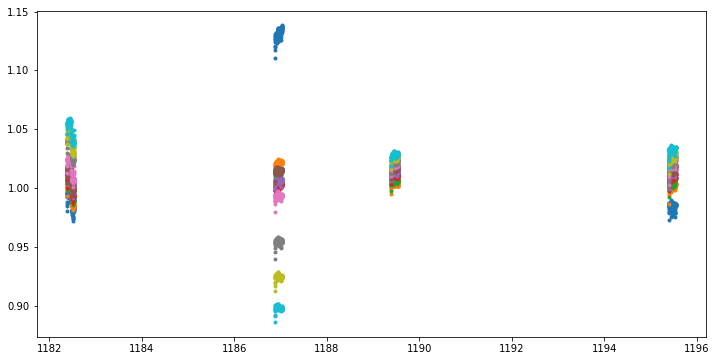

In [8]:
for i in range(10):
    flux = []
    for j in range(392):
        flux.append(flux_array[j][i]) # flux_array[image index][box number]
    plt.plot(op, (flux/np.median(flux))+(i/300), '.')

# Applying exponential model to 10 boxes

In [35]:
param

array([  1.01267456e+00,   1.09017868e+03,   4.88896985e-03])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

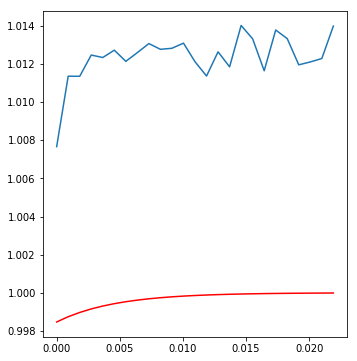

In [68]:
# defining exponential function for visit 1, orbit 2
op1        = op[23:98]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val

plt.subplot(121)
for i in range(10):
    n_flux = flux_array[23:98,i]/np.median(flux_array[23:98,i])
#     pdb.set_trace()
    param, _ = curve_fit(f, op1[0:25] - op1[0], n_flux[0:25], p0=(1, (1.5*24*60)/10, 0.03))
    if i in [5,6,7]:
        plt.plot(op1[0:25] - op1[0], f(op1[0:25] - op1[0], 1, (1.5*24*60)/10, 0.03), 'r')
        plt.plot(op1[0:25] - op1[0], n_flux[0:25])
    
#     #detrended fluxes
#     f_v1o2 = n_flux[0:25]/f(op1[0:25] - op1[0], *param)
#     f_v1o3 = n_flux[25:50]/f(op1[25:50] - op1[25], *param)
#     f_v1o4 = n_flux[50:75]/f(op1[50:75] - op1[50], *param)
    
#     flux = np.concatenate((f_v1o2,f_v1o3,f_v1o4))
# #     pdb.set_trace()
#     plt.plot(op1, flux+(i/300), '.')
#     plt.title('Exponential Detrended')
#     plt.ylim(0.98, 1.05)

# plt.subplot(122)
# for i in range(10):
#     flux = []
#     for j in range(23,98):
#         flux.append(flux_array[j][i])
#     plt.plot(op1, (flux/np.median(flux))+(i/300), '.')
#     plt.title('Original')
#     plt.ylim(0.98, 1.05)

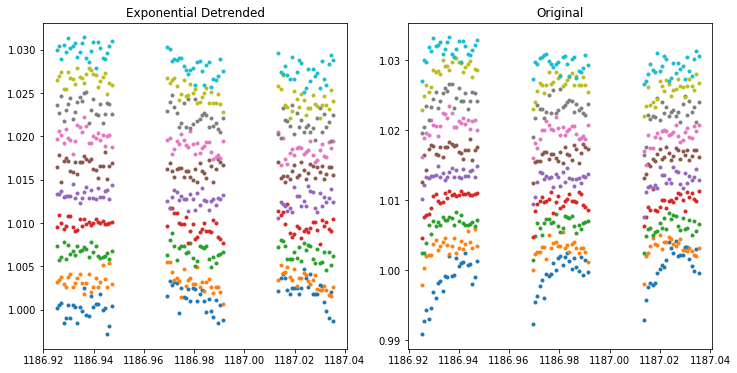

In [15]:
# defining exponential function for visit 2, orbit 2
op2 = op[121:196]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val

plt.subplot(121)
for i in range(10):
    n_flux = flux_array[121:196,i]/np.median(flux_array[121:196,i])
    param, _ = curve_fit(f, op2[0:25] - op2[0], n_flux[0:25], p0=(1, (1.5*24*60)/10, 0))
    
    #detrended fluxes
    f_v2o2 = n_flux[0:25]/f(op2[0:25] - op2[0], *param)
    f_v2o3 = n_flux[25:50]/f(op2[25:50] - op2[25], *param)
    f_v2o4 = n_flux[50:75]/f(op2[50:75] - op2[50], *param)
    
    flux = np.concatenate((f_v2o2,f_v2o3,f_v2o4))
    plt.plot(op2, flux+(i/300), '.')
    plt.title('Exponential Detrended')

plt.subplot(122)
for i in range(10):
    flux = []
    for j in range(121, 196):
        flux.append(flux_array[j][i])
    plt.plot(op2, (flux/np.median(flux))+(i/300), '.')
    plt.title('Original')

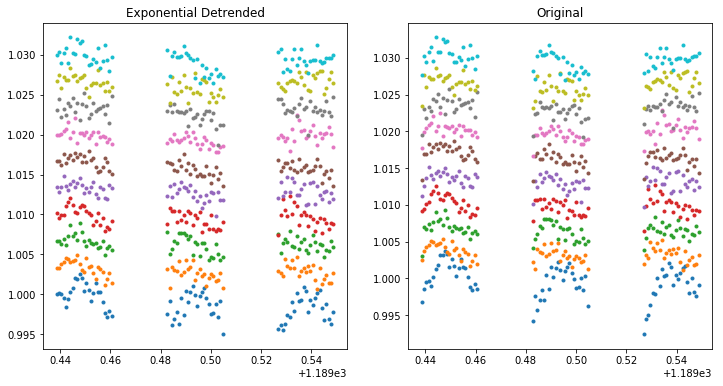

In [24]:
# defining exponential function for visit 3, orbit 2
op3 = op[219:294]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val

plt.subplot(121)
for i in range(10):
    n_flux = flux_array[219:294,i]/np.median(flux_array[219:294,i])
    param, _ = curve_fit(f, op3[0:25] - op3[0], n_flux[0:25], p0=(1, (1.5*24*60)/10, 0))
    
    #detrended fluxes
    f_v3o2 = n_flux[0:25]/f(op2[0:25] - op2[0], *param)
    f_v3o3 = n_flux[25:50]/f(op2[25:50] - op2[25], *param)
    f_v3o4 = n_flux[50:75]/f(op2[50:75] - op2[50], *param)
    
    flux = np.concatenate((f_v3o2,f_v3o3,f_v3o4))
    plt.plot(op3, flux+(i/300), '.')
    plt.title('Exponential Detrended')

plt.subplot(122)
for i in range(10):
    flux = []
    for j in range(219, 294):
        flux.append(flux_array[j][i])
    plt.plot(op3, (flux/np.median(flux))+(i/300), '.')
    plt.title('Original')

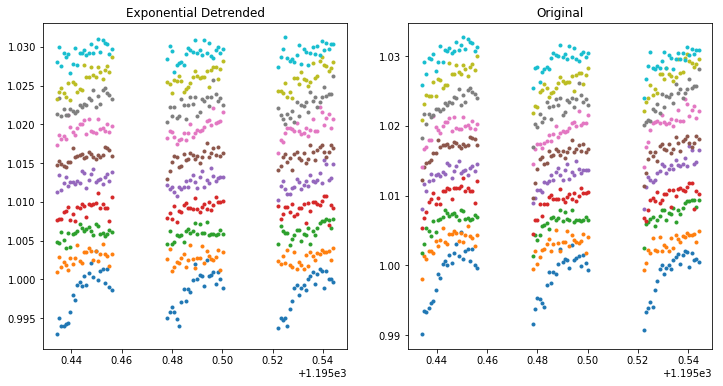

In [17]:
# defining exponential function for visit 4, orbit 2
op42        = op[317:342]
flux42      = norm_flux[317:342]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val
param, _ = curve_fit(f, op42-op42[0], flux42, p0=(1, (1.5*24*60)/10, 0))

plt.subplot(121)
for i in range(10):
    
    # normalized fluxes
    n_v4o2 = flux_array[317:342,i]/np.median(flux_array[317:342,i])
    n_v4o3 = flux_array[342:367,i]/np.median(flux_array[342:367,i])
    n_v4o4 = flux_array[367:392,i]/np.median(flux_array[367:392,i])
    
    #detrended fluxes
    f_v4o2 = n_v4o2/f(op[317:342] - op[317], *param)
    f_v4o3 = n_v4o3/f(op[342:367] - op[342], *param)
    f_v4o4 = n_v4o4/f(op[367:392] - op[367], *param)
    
    flux = np.concatenate((f_v4o2,f_v4o3,f_v4o4))
    plt.plot(op[317:392], flux+(i/300), '.')
    plt.title('Exponential Detrended')

plt.subplot(122)
for i in range(10):
    flux = []
    for j in range(317,392):
        flux.append(flux_array[j][i])
    plt.plot(op[317:392], (flux/np.median(flux))+(i/300), '.')
    plt.title('Original')

# Fitting batman model to cleaner transit light curve

In [18]:
params = batman.TransitParams()
params.t0        = 2454159.45320 + 0.01            #time of inferior conjunction
params.per       = 1.5089557                #orbital period
params.rp        = 0.135                    #planet radius (in units of stellar radii)
params.a         = 4.901                    #semi-major axis (in units of stellar radii)
params.inc       = 85.10                    #orbital inclination (in degrees)
params.ecc       = 0.                       #eccentricity
params.w         = 90.                      #longitude of periastron (in degrees)
params.u         = [0.1, 0.3]               #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"              #limb darkening model

### Grid Search

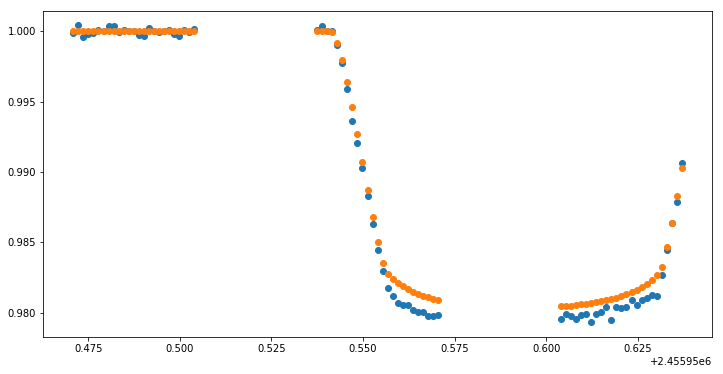

In [19]:
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val
param, _ = curve_fit(f, op[23:48]-op[23], norm_flux[23:48], p0=(1, (1.5*24*60)/10, 0))

f_v1o2 = norm_flux[23:48]/f(op[23:48] - op[23], *param)
f_v1o3 = norm_flux[48:73]/f(op[48:73] - op[48], *param)
f_v1o4 = norm_flux[73:98]/f(op[73:98] - op[73], *param)

f_v1 = np.concatenate((f_v1o2,f_v1o3,f_v1o4))
plt.plot(lc_info['time'][23:98] + jd_const, f_v1, 'o')


t = lc_info['time'][23:98] + jd_const
m = batman.TransitModel(params, t)
flux = m.light_curve(params)
plt.plot(t, flux, 'o')

Text(0.5,1,'minimizing chi squared')

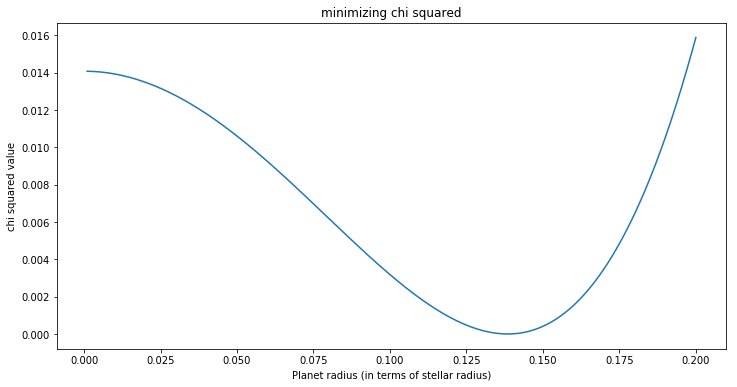

In [20]:
data = f_v1
r_guess = np.linspace(0.001, 0.2, 1000)
cs_val = np.array([])
for r in r_guess:
    params.rp = r
    m = batman.TransitModel(params, t)    
    model = m.light_curve(params)
    chi_sq = np.sum((data-model)**2/model)
    cs_val = np.append(cs_val, chi_sq)
plt.plot(r_guess, cs_val)
plt.xlabel('Planet radius (in terms of stellar radius)')
plt.ylabel('chi squared value')
plt.title('minimizing chi squared')

In [21]:
ind = np.argmin(cs_val)
best_r = r_guess[ind]
print('best fit rp:', best_r)

best fit rp: 0.138447447447


##### Finding r for 10 different wavelength ranges

C:\Users\rafia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\rafia\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


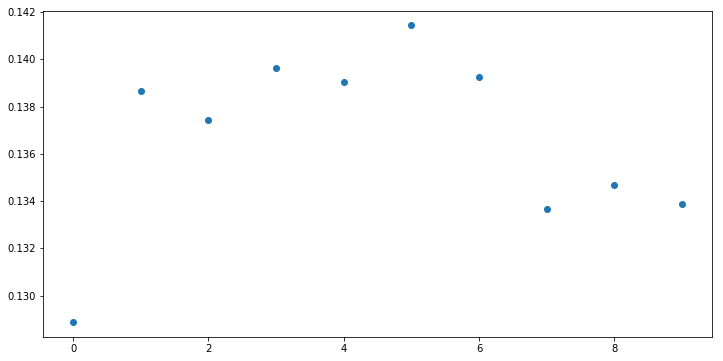

In [73]:
best_r = np.array([])

def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val


for i in range(10):
    n_flux = flux_array[23:98,i]/np.median(flux_array[23:98,i])
    param, _ = curve_fit(f, op1[0:25] - op[0], n_flux[0:25], p0=(1, (1.5*24*60)/10, 0))
    cs_val = np.array([])
    
    #detrended fluxes
    f_v1o2 = n_flux[0:25]/f(op1[0:25] - op[0], *param)
    f_v1o3 = n_flux[25:50]/f(op1[25:50] - op[25], *param)
    f_v1o4 = n_flux[50:75]/f(op1[50:75] - op[50], *param)
    
    data = np.concatenate((f_v1o2,f_v1o3,f_v1o4))
    
    m = batman.TransitModel(params, t)
    for r in r_guess:
        params.rp = r    
        model = m.light_curve(params)
        chi_sq = np.sum((data-model)**2/model)
        cs_val = np.append(cs_val, chi_sq)
    ind = np.argmin(cs_val)
    best_r = np.append(best_r, r_guess[ind])
plt.plot(best_r, 'o')

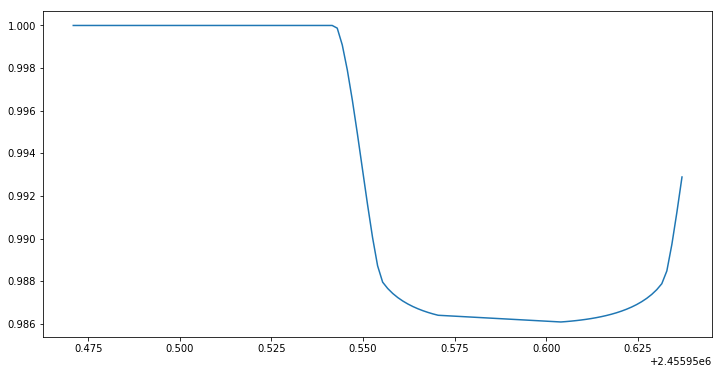

In [76]:
def f(x, r):
    params.rp = r
    m = batman.TransitModel(params, x)
    val = m.light_curve(params)
    return val
param, _ = curve_fit(f, t, norm_flux[23:98], p0=(0.135))
plt.plot(t, f(t, *param))

### Least squares

In [23]:
def f(x, a, b):
    val = a+(b*x)
    return val
param, _ = curve_fit(f, op[23:48]-op[23], norm_flux[23:48], p0=(1, (1.5*24*60)/10, 0))

f_v1o2 = norm_flux[23:48]/f(op[23:48] - op[23], *param)
f_v1o3 = norm_flux[48:73]/f(op[48:73] - op[48], *param)
f_v1o4 = norm_flux[73:98]/f(op[73:98] - op[73], *param)

f_v1 = np.concatenate((f_v1o2,f_v1o3,f_v1o4))
plt.plot(lc_info['time'][23:98] + jd_const, f_v1, 'o')


t = lc_info['time'][23:98] + jd_const
m = batman.TransitModel(params, t)    
flux = m.light_curve(params)
plt.plot(t, flux, 'o')

TypeError: f() takes 3 positional arguments but 4 were given